# Импорт библиотек

In [16]:
import pandas as pd
import numpy as np

# для визуализации
import matplotlib.pyplot as plt
# для работы с данными
from sklearn.preprocessing import FunctionTransformer
# для разделения  на тренировочную и тестовую выборки
from sklearn.model_selection import StratifiedKFold
# для метрик и baseline моделей
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
# для поиска пераметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# методы
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
# интерпретация
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

# Определение полезных функций

In [17]:
# проверка тестовой выборки - визуализация с раскраской данных по типу
def DrawTestData(X_test_p, y_pred_p, MaxErr_test_p, title_p):
  test_data_tree = pd.DataFrame(X_test_p)
  test_data_tree.insert(0, '0', y_pred_p)
  test_data_tree.insert(1, '1', MaxErr_test_p)
  test_data_tree.columns=data.columns

  # группируем и отображаем с раскраской
  groups = test_data_tree.groupby('ErrBinary')
  plt.yscale('log')
  for name, group in groups:
      plt.plot(group.SKO, group.MaxErr, marker='o', linestyle='', markersize=1, label=name)
  plt.legend()
  plt.xlabel('SKO')
  plt.ylabel('log10(' + data.MaxErr.name + ')')
  plt.grid()
  plt.title(title_p)

In [18]:
def PrintAllMetrics(y_test_p, y_pred_p, title_p):
  print(title_p, ':')

  m=confusion_matrix(y_test_p, y_pred_p)

  print('   FP %i   FN %i   precision  %.4f   F1-score %.4f   Fbeta-score %.4f' %
   (m[0,1],
    m[1,0],
    precision_score(y_test_p, y_pred_p, zero_division=0),
    f1_score(y_test_p, y_pred_p),
    fbeta_score(y_test_p, y_pred_p, beta=0.5)))

In [19]:
# задаем метрику для всех поисков параметров
my_metrica = 'precision'
# пробовала также f1, распределение метрик немного меняется, но принципиально лучше не становится

# Загрузка и предварительная обработка данных


## Загрузка данных

In [20]:
#загрузка данных
from google.colab import drive
drive.mount('/content/gdrive')

data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/misel_clear_3.csv')

data.columns
data.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(29233, 7)

## Дополнительная обработка данных


In [21]:
# попробуем удалить данные, у которых СКО <0.4
#data = data.loc[data['SKO'] > 0.4]
#data.describe()
#(не помогло, метрики стали хуже)

In [22]:
# попробуем удалить SPAN
#del data['Span']
#data.columns
#(тоже не помогло, метрики стали хуже)

In [23]:
# попробуем разбить с31,s31,с22,s22 на 2 колонки каждый: значение по модулю и знак
#data['c31_sign']=np.sign(data['c31'])
#data['c31_abs']=np.abs(data['c31'])

#data['s31_sign']=np.sign(data['s31'])
#data['s31_abs']=np.abs(data['s31'])

#data['c22_sign']=np.sign(data['c22'])
#data['c22_abs']=np.abs(data['c22'])

#data['s22_sign']=np.sign(data['s22'])
#data['s22_abs']=np.abs(data['s22'])

#del data['c31']
#del data['s31']
#del data['c22']
#del data['s22']

#data

#(и это тоже не помогло, метрики не изменились)

## Основная обработка данных

In [24]:
# берем колоку с ошибками из таблицы
ErrBinary=data.MaxErr.values
# задаем диапазоны, 1 - алгоритм сошелся, 0 - алгоритм не сошелся
bins = [-np.inf, 10E-5, np.inf]
labels = [1, 0]

transformer = FunctionTransformer(func=pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False})
# создаем новый массив
ErrBinary=transformer.fit_transform(ErrBinary)
# добавляем его к нашим данным
data.insert(0, 'ErrBinary', ErrBinary)

success -  28115
failure -  1118


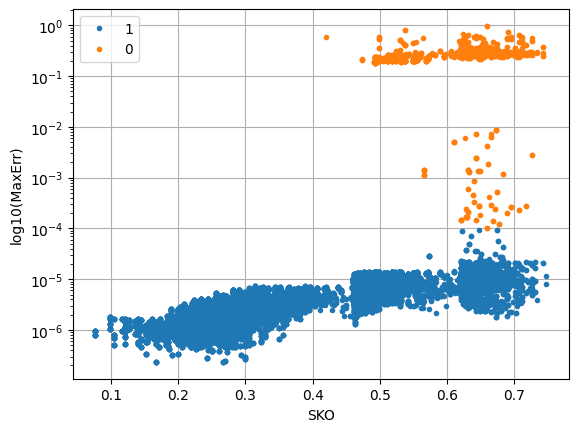

In [25]:
# проверка - сколько 1 и сколько 0?
print('success - ', len(data[data['ErrBinary']==1]))
print('failure - ', len(data[data['ErrBinary']==0]))

# проверка - визуализация с раскраской данных по типу
groups = data.groupby('ErrBinary')

plt.yscale('log')
for name, group in groups:
    plt.plot(group.SKO, group.MaxErr, marker='o', linestyle='', markersize=3, label=name)
plt.legend()
plt.xlabel('SKO')
plt.ylabel('log10(' + data.MaxErr.name + ')')
plt.grid()

# Разделение на тренировочную и тестовую выборки

In [26]:
# классы - колонка ErrBinary
y = data.values[::, 0:1]
# признаки - все кроме MaxErr и ErrBinary
X = data.values[::, 2:]
# MaxErr сохраним отдельно, чтобы потом использовать для проверки
MaxErr = data.values[::, 1:2]

Делим на тренировочную и тестовую выборки

In [27]:
skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y, MaxErr):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    MaxErr_train, MaxErr_test = MaxErr[train_index], MaxErr[test_index]

# проверка
print('y_test  - success - ', np.count_nonzero(y_test==1))
print('y_test  - failure - ', np.count_nonzero(y_test==0))
print('y_train - success - ', np.count_nonzero(y_train==1))
print('y_train - failure - ', np.count_nonzero(y_train==0))

y_test  - success -  5623
y_test  - failure -  223
y_train - success -  22492
y_train - failure -  895


# DummyClassifier и LogisticRegression

In [28]:
# DummyClassifier и ее метрики
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train);

y_pred_dummy = dummy_clf.predict(X_test)
PrintAllMetrics(y_test, y_pred_dummy, 'Константа')

Константа :
   FP 223   FN 0   precision  0.9619   F1-score 0.9806   Fbeta-score 0.9692


In [29]:
# логистическая регрессия и ее метрики
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);

y_pred_log_reg = log_reg.predict(X_test)
PrintAllMetrics(y_test, y_pred_log_reg, 'Логистическая регрессия')

Логистическая регрессия :
   FP 193   FN 116   precision  0.9661   F1-score 0.9727   Fbeta-score 0.9688


# Метод ближайших соседей

In [30]:
neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')
neighbors.fit(X_train, y_train)

y_pred_neighbors = neighbors.predict(X_test)
PrintAllMetrics(y_test, y_pred_neighbors, 'Ближайшие соседи')

Ближайшие соседи :
   FP 148   FN 461   precision  0.9721   F1-score 0.9443   Fbeta-score 0.9608


# Дерево решений

In [31]:
# дерево решений, max_depth - кол-во уровней
clf = DecisionTreeClassifier(max_depth=5, random_state=2023)
clf = clf.fit(X_train, y_train)

y_pred_tree = clf.predict(X_test)
PrintAllMetrics(y_test, y_pred_tree, 'Дерево решений')

Дерево решений :
   FP 196   FN 79   precision  0.9659   F1-score 0.9758   Fbeta-score 0.9698


In [32]:
# визуализация дерева
f_names = data.columns[2:]

dot_data = export_graphviz(
  clf,
  out_file=None,
  feature_names=f_names,
  class_names=['false','true'],
  filled=True,
  rounded=True,
  special_characters=True
)
#graph = graphviz.Source(dot_data)
#graph

# Случайный лес

In [33]:
# случайный лес
rforest = RandomForestClassifier(random_state=2023)
rforest.fit(X_train, y_train)
y_pred_rforest = rforest.predict(X_test)
# метрики
PrintAllMetrics(y_test, y_pred_rforest, 'Случайный лес')

Случайный лес :
   FP 169   FN 320   precision  0.9691   F1-score 0.9559   Fbeta-score 0.9638


In [34]:
parameters = {
    'n_estimators': np.arange(10, 200, 50),
    'max_depth' : np.arange(10, 50, 10),
    'max_features' : np.arange(2, 12, 2),
    'random_state': [2023]
}

#GridSearchCV
model=RandomForestClassifier()
forest_best = RandomizedSearchCV(model,
                                 parameters,
                                 scoring = my_metrica,
                                 cv = 5,
                                 n_jobs=-1,
                                 verbose=2,
                                 refit=True)
forest_best.fit(X_train, y_train)

best_parameters = forest_best.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
max_depth: 20
max_features: 8
n_estimators: 10
random_state: 2023


In [35]:
y_pred_rforest_best = forest_best.predict(X_test)
PrintAllMetrics(y_test, y_pred_rforest_best, 'Случайный лес с лучшими параметрами')

Случайный лес с лучшими параметрами :
   FP 153   FN 395   precision  0.9716   F1-score 0.9502   Fbeta-score 0.9629


# Беггинг

In [36]:
# беггинг
bg = BaggingClassifier(DecisionTreeClassifier(),n_estimators=300, random_state=2023)
bg.fit(X_train, y_train)
y_pred_bg = bg.predict(X_test)

PrintAllMetrics(y_test, y_pred_bg, 'Беггинг')

Беггинг :
   FP 161   FN 355   precision  0.9703   F1-score 0.9533   Fbeta-score 0.9635


# Бустинг

In [37]:
xgb_model = XGBClassifier(booster='dart',
                          max_depth=5,
                          gamma=0)
xgb_model.fit(X_train, y_train, eval_metric=['auc', 'error'])

y_pred_boost = xgb_model.predict(X_test)

PrintAllMetrics(y_test, y_pred_boost, 'Бустинг')

Бустинг :
   FP 155   FN 304   precision  0.9717   F1-score 0.9586   Fbeta-score 0.9664


In [38]:
# бустинг, подбор параметров
model = XGBClassifier()
parameters = {'n_estimators': np.arange(1000, 2500, 100),
              'max_depth': [3,5,7],
              'objective': ['binary:logistic'],
              'min_child_weight': [1, 5, 10],
              'gamma': [5, 7, 8, 10],
              'learning_rate': np.linspace(0.01, 1, 5),
              'colsample_bytree': np.linspace(0.5, 0.98, 5),
              'subsample': np.linspace(0.7, 0.9, 5),
              'random_state': [2023]
             }

#GridSearchCV
#RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(model,
                                       parameters,
                                       scoring=my_metrica,
                                       cv = 10,
                                       n_jobs=-1,
                                       verbose=2,
                                       refit=True)

xgb_random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                   param_distributions={'colsample_bytree': array([0.5 , 0.62, 0.74, 0.86, 0.98]),
                                        'gamma': [5, 7, 8, 10],
                                        'learning_rate': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': array([1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000,
       2100, 2200, 2300, 2400]),
                                        'objective': ['binary:logistic'],
                                        'random_state': [2023],
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 ])},
                   scoring='precision', verbose=2)

In [39]:
y_pred_boos_best = xgb_random_search.predict(X_test)
PrintAllMetrics(y_test, y_pred_boos_best, 'Бустинг с лучшими параметрами')

Бустинг с лучшими параметрами :
   FP 155   FN 304   precision  0.9717   F1-score 0.9586   Fbeta-score 0.9664


# Сводные данные по всем моделям

##Метрики

In [40]:
# метрики
print('метрика', my_metrica)
PrintAllMetrics(y_test, y_pred_log_reg, 'Логистическая регрессия')
PrintAllMetrics(y_test, y_pred_neighbors, 'Ближайшие соседи')
PrintAllMetrics(y_test, y_pred_tree, 'Дерево решений')
PrintAllMetrics(y_test, y_pred_rforest, 'Случайный лес')
PrintAllMetrics(y_test, y_pred_rforest_best, 'Случайный лес с лучшими параметрами')
PrintAllMetrics(y_test, y_pred_bg, 'Беггинг')
PrintAllMetrics(y_test, y_pred_boost, 'Бустинг')
PrintAllMetrics(y_test, y_pred_boos_best, 'Бустинг с лучшими параметрами')


метрика precision
Логистическая регрессия :
   FP 193   FN 116   precision  0.9661   F1-score 0.9727   Fbeta-score 0.9688
Ближайшие соседи :
   FP 148   FN 461   precision  0.9721   F1-score 0.9443   Fbeta-score 0.9608
Дерево решений :
   FP 196   FN 79   precision  0.9659   F1-score 0.9758   Fbeta-score 0.9698
Случайный лес :
   FP 169   FN 320   precision  0.9691   F1-score 0.9559   Fbeta-score 0.9638
Случайный лес с лучшими параметрами :
   FP 153   FN 395   precision  0.9716   F1-score 0.9502   Fbeta-score 0.9629
Беггинг :
   FP 161   FN 355   precision  0.9703   F1-score 0.9533   Fbeta-score 0.9635
Бустинг :
   FP 155   FN 304   precision  0.9717   F1-score 0.9586   Fbeta-score 0.9664
Бустинг с лучшими параметрами :
   FP 155   FN 304   precision  0.9717   F1-score 0.9586   Fbeta-score 0.9664


## Визуализация

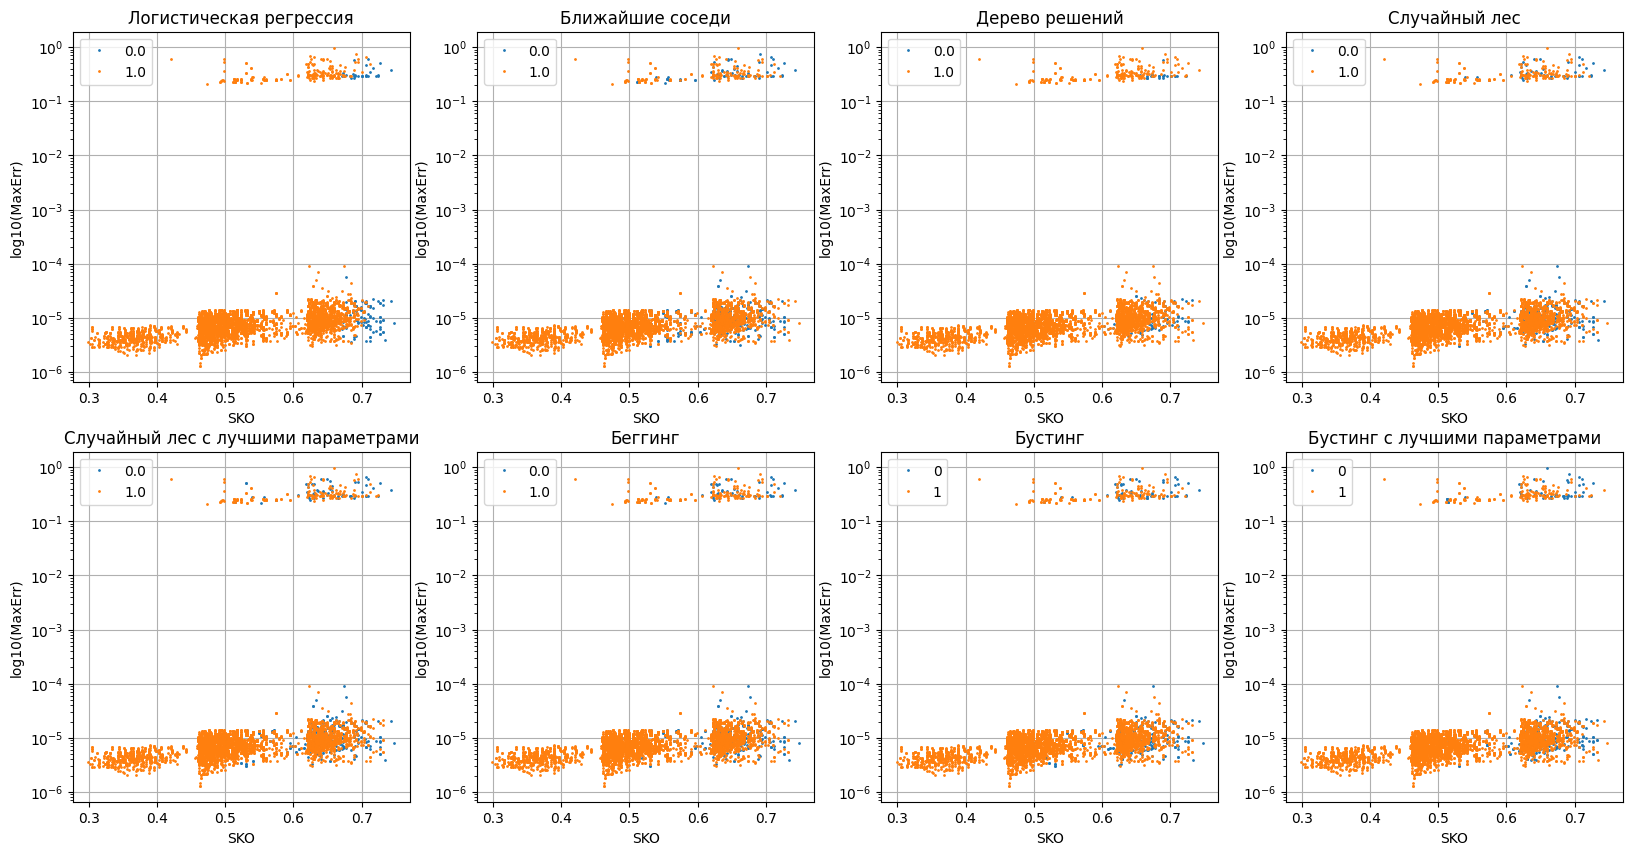

In [41]:
# визуализация результатов
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
DrawTestData(X_test, y_pred_log_reg, MaxErr_test, 'Логистическая регрессия')
plt.subplot(2, 4, 2)
DrawTestData(X_test, y_pred_neighbors, MaxErr_test, 'Ближайшие соседи')
plt.subplot(2, 4, 3)
DrawTestData(X_test, y_pred_tree, MaxErr_test, 'Дерево решений')
plt.subplot(2, 4, 4)
DrawTestData(X_test, y_pred_rforest, MaxErr_test, 'Случайный лес')

plt.subplot(2, 4, 5)
DrawTestData(X_test, y_pred_rforest_best, MaxErr_test, 'Случайный лес с лучшими параметрами')
plt.subplot(2, 4, 6)
DrawTestData(X_test, y_pred_bg, MaxErr_test, 'Беггинг')
plt.subplot(2, 4, 7)
DrawTestData(X_test, y_pred_boost, MaxErr_test, 'Бустинг')
plt.subplot(2, 4, 8)
DrawTestData(X_test, y_pred_boos_best, MaxErr_test, 'Бустинг с лучшими параметрами')


# Интерпретация моделей

##Визуализация
Попробуем визуализировать важность признаков для всех моделей

In [42]:
# функция вычисляет важность признаков и отрисовывает
def DrawImportance(model_p, x_test_p, y_test_p, title_p, fig_p, ax_p):
  importances = permutation_importance(model_p, x_test_p, y_test_p, n_repeats=10, random_state=2023, n_jobs=-1)
  forest_importances = pd.Series(importances.importances_mean, index=data.columns[2:])

  forest_importances.plot.bar(yerr=importances.importances_std, ax=ax_p, figsize=(20, 10))
  ax_p.set_title(title_p)
  fig_p.tight_layout()

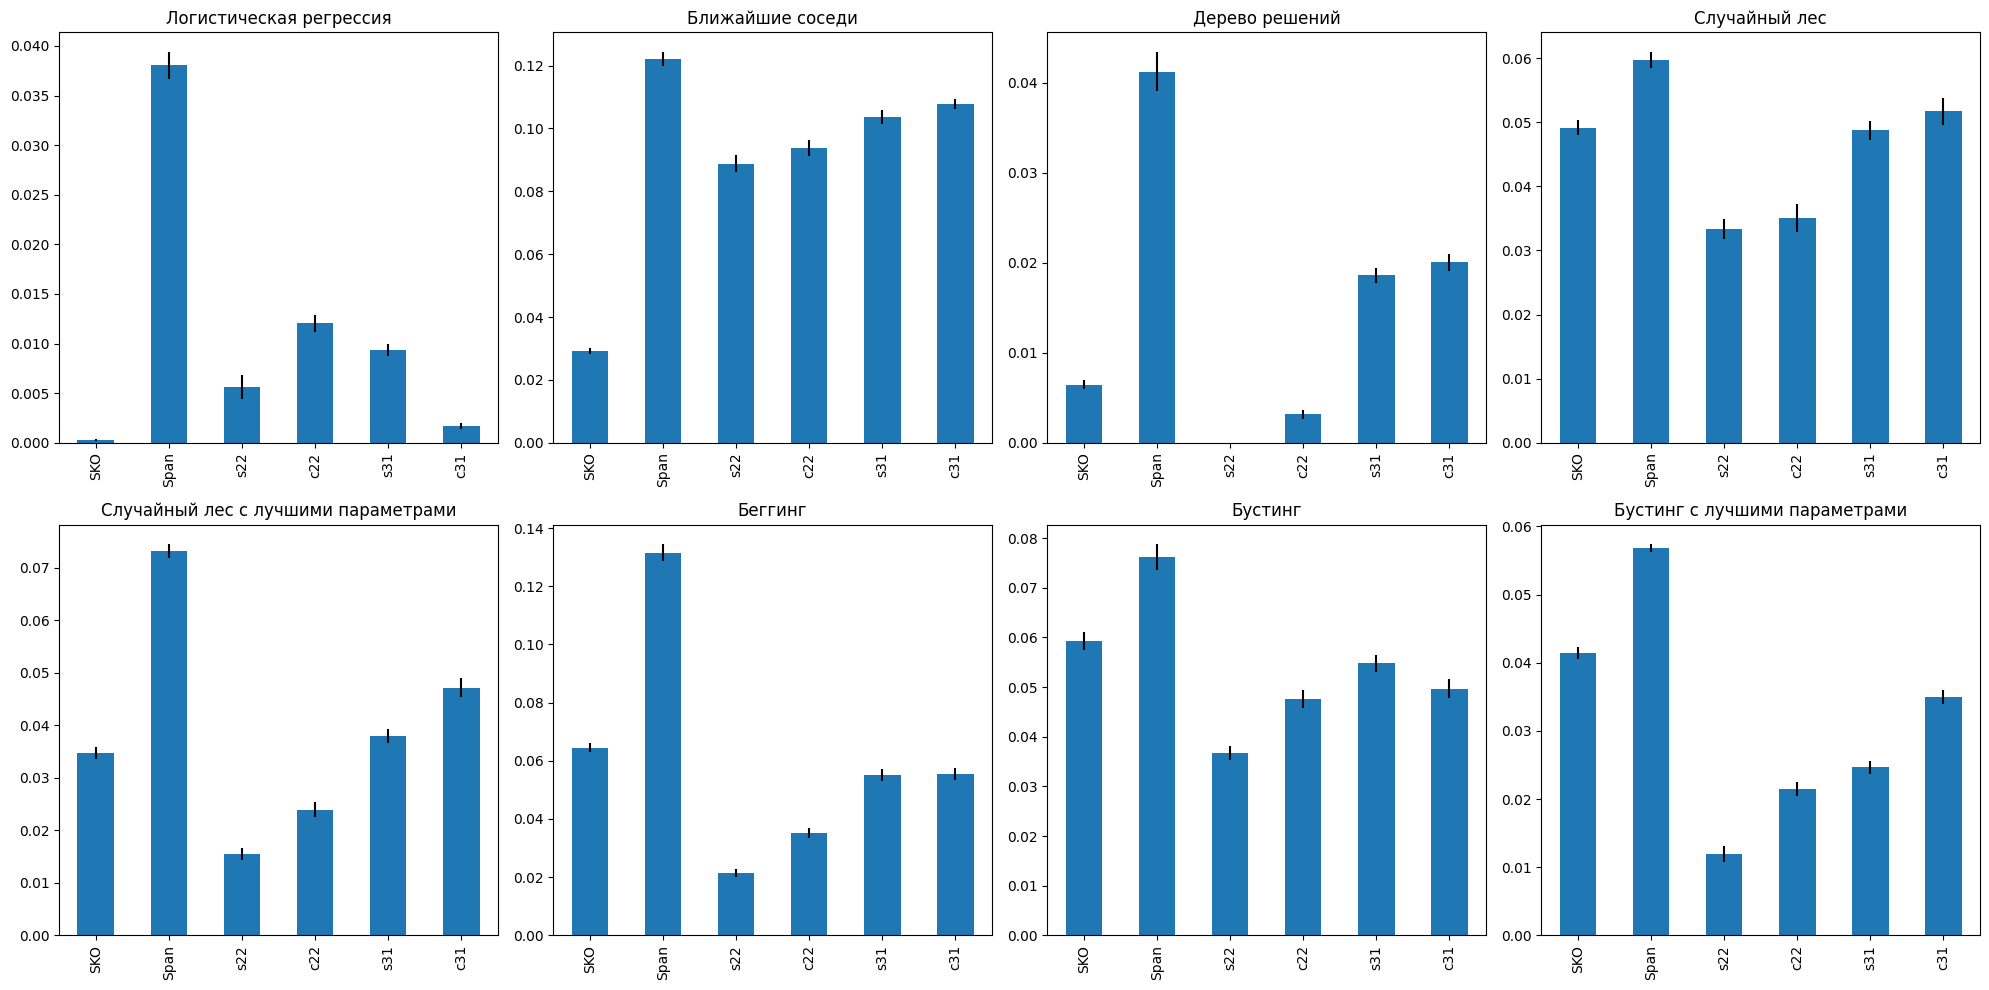

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=4)

DrawImportance(log_reg, X_test, y_pred_log_reg, 'Логистическая регрессия', fig, ax[0,0])
DrawImportance(neighbors, X_test, y_pred_neighbors, 'Ближайшие соседи', fig, ax[0,1])
DrawImportance(clf, X_test, y_pred_tree, 'Дерево решений', fig, ax[0,2])
DrawImportance(rforest, X_test, y_pred_rforest, 'Случайный лес', fig, ax[0,3])

DrawImportance(forest_best, X_test, y_pred_rforest_best, 'Случайный лес с лучшими параметрами', fig, ax[1,0])
DrawImportance(bg, X_test, y_pred_bg, 'Беггинг', fig, ax[1,1])
DrawImportance(xgb_model, X_test, y_pred_boost, 'Бустинг', fig, ax[1,2])
DrawImportance(xgb_random_search, X_test, y_pred_boos_best, 'Бустинг с лучшими параметрами', fig, ax[1,3])

## Выводы по интерпретации моделей
Для разных методов распределение важности признаков немного отличается, однако общим является более сама выокоая важность у признака Span. У многих методов вторым по значимости признаком является SKO.

Признаки с22,s22, с31,s31 влияют меньше. При этом, у большинства моделей с31 и s31 влияют больше чем с22 и s22.

# Выводы

**Были исследованы методы:**

*   логистической регрессии
*   ближайших соседей
*   дерева решений
*   случайный лес
*   беггинг
*   бустинг

Для методов случайного леса и бустинга был произведен подбор параметров и выявлены наилучшие параметры.

Однако, все выбранные метрики, а также визуализация, показывают, что ни один из исследуемых методов не справился с задачей.

**Метрики**

Была сделана попытка использовать разные метрики при подобре параметров, а именно f1 и precision. Разница в результатах незначительная:
```
метрика - precision:
  Случайный лес с лучшими параметрами :
     FP 153   FN 395   precision  0.9716   F1-score 0.9502   Fbeta-score 0.9629
  Бустинг с лучшими параметрами :
     FP 159   FN 291   precision  0.9710   F1-score 0.9595   Fbeta-score 0.9664
метрика f1
  Случайный лес с лучшими параметрами :
     FP 166   FN 250   precision  0.9700   F1-score 0.9627   Fbeta-score 0.9671
  Бустинг с лучшими параметрами :
     FP 173   FN 207   precision  0.9690   F1-score 0.9661   Fbeta-score 0.9679
```








**Предварительная обработка данных**

Было несколько идей по дополнительной предварительной обработке данных (см. раздел "Дополнительная обработка данных"). Далее приводятся результаты метрик для разных вариантов предварительной обработки:

Если удалить все данные с SKO<0.4:
```
метрика precision
Логистическая регрессия :
   FP 218   FN 6     precision  0.9286   F1-score 0.9620   Fbeta-score 0.9417
Дерево решений :
   FP 194   FN 128   precision  0.9332   F1-score 0.9440   Fbeta-score 0.9375
Случайный лес :
   FP 181   FN 204   precision  0.9357   F1-score 0.9319   Fbeta-score 0.9342
Случайный лес с лучшими параметрами :
   FP 174   FN 257   precision  0.9369   F1-score 0.9230   Fbeta-score 0.9313
Беггинг :
   FP 180   FN 226   precision  0.9356   F1-score 0.9279   Fbeta-score 0.9325
Бустинг :
   FP 167   FN 170   precision  0.9411   F1-score 0.9406   Fbeta-score 0.9409
Бустинг с лучшими параметрами :
   FP 176   FN 159   precision  0.9384   F1-score 0.9412   Fbeta-score 0.9395
```
Если удалить колонку Span:
```
метрика f1
Логистическая регрессия :
   FP 218   FN 23    precision  0.9625   F1-score 0.9789   Fbeta-score 0.9690
Дерево решений :
   FP 177   FN 186   precision  0.9685   F1-score 0.9677   Fbeta-score 0.9682
Случайный лес :
   FP 174   FN 342   precision  0.9681   F1-score 0.9534   Fbeta-score 0.9622
Случайный лес с лучшими параметрами :
   FP 180   FN 202   precision  0.9679   F1-score 0.9660   Fbeta-score 0.9671
Беггинг :
   FP 160   FN 380   precision  0.9704   F1-score 0.9510   Fbeta-score 0.9625
Бустинг :
   FP 156   FN 316   precision  0.9714   F1-score 0.9574   Fbeta-score 0.9658
Бустинг с лучшими параметрами :
   FP 190   FN 84    precision  0.9668   F1-score 0.9759   Fbeta-score 0.9704
```
Если разбить с31,s31,с22,s22 на модуль и знак:
```
метрика f1
Логистическая регрессия :
   FP 218   FN 23    precision  0.9625   F1-score 0.9789   Fbeta-score 0.9690
Дерево решений :
   FP 177   FN 186   precision  0.9685   F1-score 0.9677   Fbeta-score 0.9682
Случайный лес :
   FP 174   FN 342   precision  0.9681   F1-score 0.9534   Fbeta-score 0.9622
Случайный лес с лучшими параметрами :
   FP 180   FN 202   precision  0.9679   F1-score 0.9660   Fbeta-score 0.9671
Беггинг :
   FP 160   FN 380   precision  0.9704   F1-score 0.9510   Fbeta-score 0.9625
Бустинг :
   FP 156   FN 316   precision  0.9714   F1-score 0.9574   Fbeta-score 0.9658
Бустинг с лучшими параметрами :
   FP 190   FN 84    precision  0.9668   F1-score 0.9759   Fbeta-score 0.9704  
```
Если удалить с31,s31,с22,s22 совсем:
```
метрика precision
Логистическая регрессия :
   FP 205   FN 73   precision  0.9644   F1-score 0.9756   Fbeta-score 0.9688
Ближайшие соседи :
   FP 114   FN 284  precision  0.9791   F1-score 0.9641   Fbeta-score 0.9730
Дерево решений :
   FP 207   FN 46   precision  0.9642   F1-score 0.9778   Fbeta-score 0.9696
Случайный лес :
   FP 154   FN 153  precision  0.9726   F1-score 0.9727   Fbeta-score 0.9727
Случайный лес с лучшими параметрами :
   FP 154   FN 151  precision  0.9726   F1-score 0.9729   Fbeta-score 0.9727
Беггинг :
   FP 154   FN 142  precision  0.9727   F1-score 0.9737   Fbeta-score 0.9731
Бустинг :
   FP 200   FN 90   precision  0.9651   F1-score 0.9745   Fbeta-score 0.9688
Бустинг с лучшими параметрами :
   FP 200   FN 67   precision  0.9653   F1-score 0.9765   Fbeta-score 0.9697
```



Таким образом, ни один из рассмотренных методов не достиг требуемой цели. Попытка поменять метрики, или добавить дополнительную предобработку данных также не помогла. Вероятно, для этих данных, нужно использовать более сложные модели, например нейронные сети, которые представляются слишком трудоемкими для базового уровня.

Тем не менее, в результате прохождения данного курса были получены знания по использованию различных методов машинного обучения при работе с данными, и получены практические навыки их использования при помощи jupyter notebook и google collab. В дальнейшем полученные знания и практические навыки могут быть при необходимости использованы при работе с данными, полученными в результате профессиональной деятельности. Думаю, можно считать, что цель прохождения курса достигнута.